In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import brentq
from scipy.stats import norm
from scipy.optimize import least_squares

import matplotlib.pyplot as plt

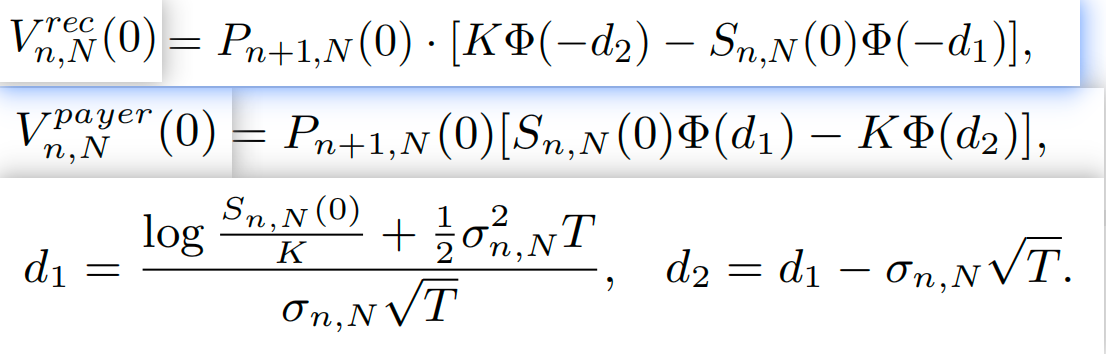

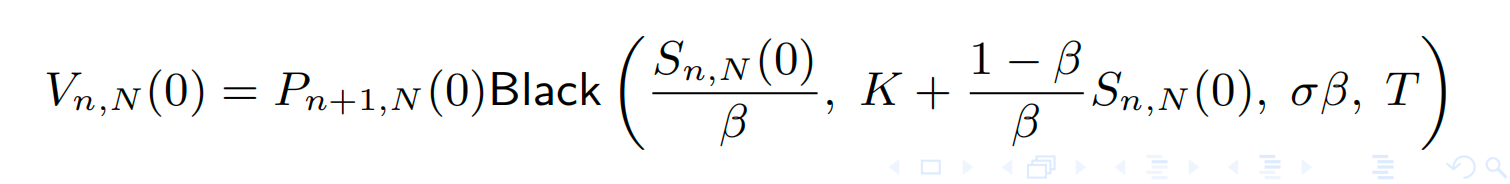

# DD

In [2]:
# def black76_Call(F, K, T, r, sigma):
#     discount_factor = np.exp(-r*T)
#     #F = S0*np.exp(r*T)
#     d1 = (np.log(F/K)+(1/2)*(sigma**2)*T)/(sigma*np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     price = discount_factor * ((F*norm.cdf(d1)) - (K*norm.cdf(d2)))
#     return price
# def black76_Put(F, K, T, r, sigma):
#     discount_factor = np.exp(-r*T)
#     #F = S0*np.exp(r*T)
#     d1 = (np.log(F/K)+1/2*(sigma**2)*T)/(sigma*np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     price = discount_factor * ((K*norm.cdf(-d2)) - (F*norm.cdf(-d1)))
#     return price

In [3]:
def cal_v_swaption_rec(S, PVBP, vol, K, T):
    d1 = (np.log(S/K) + 0.5*vol**2*T)/(vol*np.sqrt(T))
    d2 = d1-vol*np.sqrt(T)
    return PVBP*(K*norm.cdf(-d2) - S*norm.cdf(-d1))

def cal_v_swaption_payer(S, PVBP, vol, K, T):
    d1 = (np.log(S/K) + 0.5*vol**2*T)/(vol*np.sqrt(T))
    d2 = d1-vol*np.sqrt(T)
    return PVBP*(S*norm.cdf(d1) - K*norm.cdf(d2))

#OTM S < K
def ivol_payer(S, PVBP, price, K, T):
    try:
        return brentq(lambda vol: price - cal_v_swaption_payer(S, PVBP, vol, K, T), 1e-12, 1000.0)
    except Exception:
        return np.nan
#OTM S > K
def ivol_rec(S, PVBP, price, K, T):
    try:
        return brentq(lambda vol: price - cal_v_swaption_rec(S, PVBP, vol, K, T), 1e-12, 1000.0)
    except Exception:
        return np.nan

In [4]:
#payer-call receiver-put
def black76_Call(F, K, T, sigma):
    #discount_factor = np.exp(-r*T)
    #F = S0*np.exp(r*T)
    d1 = (np.log(F/K)+(1/2)*(sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = F*norm.cdf(d1) - K*norm.cdf(d2)
    return price
def black76_Put(F, K, T, sigma):
    #discount_factor = np.exp(-r*T)
    #F = S0*np.exp(r*T)
    d1 = (np.log(F/K)+1/2*(sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = K*norm.cdf(-d2) - F*norm.cdf(-d1)
    return price

def dd_payer(PVBP, S, K, vol, T, beta):
    return PVBP*black76_Call(S/beta, K + (1-beta)/beta*S, T, vol*beta)

def dd_rec( PVBP, S, K, vol, T, beta):
    return PVBP*black76_Put(S/beta, K + (1-beta)/beta*S, T, vol*beta)

In [5]:
def ddcalibration(beta, row):
    S = row.iloc[2]
    PVBP = row.iloc[3]
    T = row.iloc[0]
    
    err = 0
    vols = row.iloc[4:]
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    

    for i, bp_change in enumerate(bp_changes):
        #rec
        if bp_change < 0:
            K = S+bp_change
            # print(PVBP, S, K, vols.iloc[5], T, beta[0])
            price = dd_rec(PVBP, S, K, vols.iloc[5], T, beta[0])
            # print(price)
            # return
            err += (vols.iloc[i] - ivol_rec(S, PVBP, price, K, T))**2
        #payer
        else:
            K = S+bp_change
            price = dd_payer(PVBP, S, K, vols.iloc[5], T, beta[0])
            #print(price)
            err += (vols.iloc[i] - ivol_payer(S, PVBP, price, K, T))**2

    return err

In [6]:
def DD_fit_beta(row):
    guess = [0.7]
    bounds = (0,1)
    res = least_squares(lambda beta: ddcalibration(beta, row), guess, bounds=bounds)

    return res.x[0]

In [7]:
# def dd_vol(row):
#     beta = row.iloc[-1]
#     S = row.iloc[2]
#     K = S
#     PVBP = row.iloc[3]
#     T = row.iloc[0]
#     ATMvol = row.iloc[9]
    
#     price = dd_rec(PVBP, S, K, ATMvol, T, beta)
#     return ivol_rec(S, PVBP, price, K, T)

In [8]:
def cal_dd_vol(row):
    beta = row.iloc[-2]
    S = row.iloc[2]
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    PVBP = row.iloc[3]
    T = row.iloc[0]
    ATMvol = row.iloc[9]

    dd_vols = []

    for i, bp_change in enumerate(bp_changes):
        #rec
        if bp_change < 0:
            K = S+bp_change
            # print(PVBP, S, K, vols.iloc[5], T, beta[0])
            price = dd_rec(PVBP, S, K, ATMvol, T, beta)
            # print(price)
            # return
            dd_vols.append(ivol_rec(S, PVBP, price, K, T))
        #payer
        else:
            K = S+bp_change
            price = dd_payer(PVBP, S, K, ATMvol, T, beta)
            #print(price)
            
            dd_vols.append(ivol_payer(S, PVBP, price, K, T))
    
    
    return dd_vols

In [9]:
ivol = pd.read_excel('IR Data.xlsx', sheet_name = 'Swaption', skiprows = 2)
ivol[ivol.columns[2:]] = ivol[ivol.columns[2:]]/100

fsr = pd.read_csv('fsr.csv')
fsr[ivol.columns[2:]] = ivol[ivol.columns[2:]]
beta = [DD_fit_beta(fsr.iloc[i]) for i in range(len(fsr))]
fsr['beta'] = beta

# dd_vols = [dd_vol(fsr.iloc[i]) for i in range(len(fsr))]
# fsr['vol'] = dd_vols

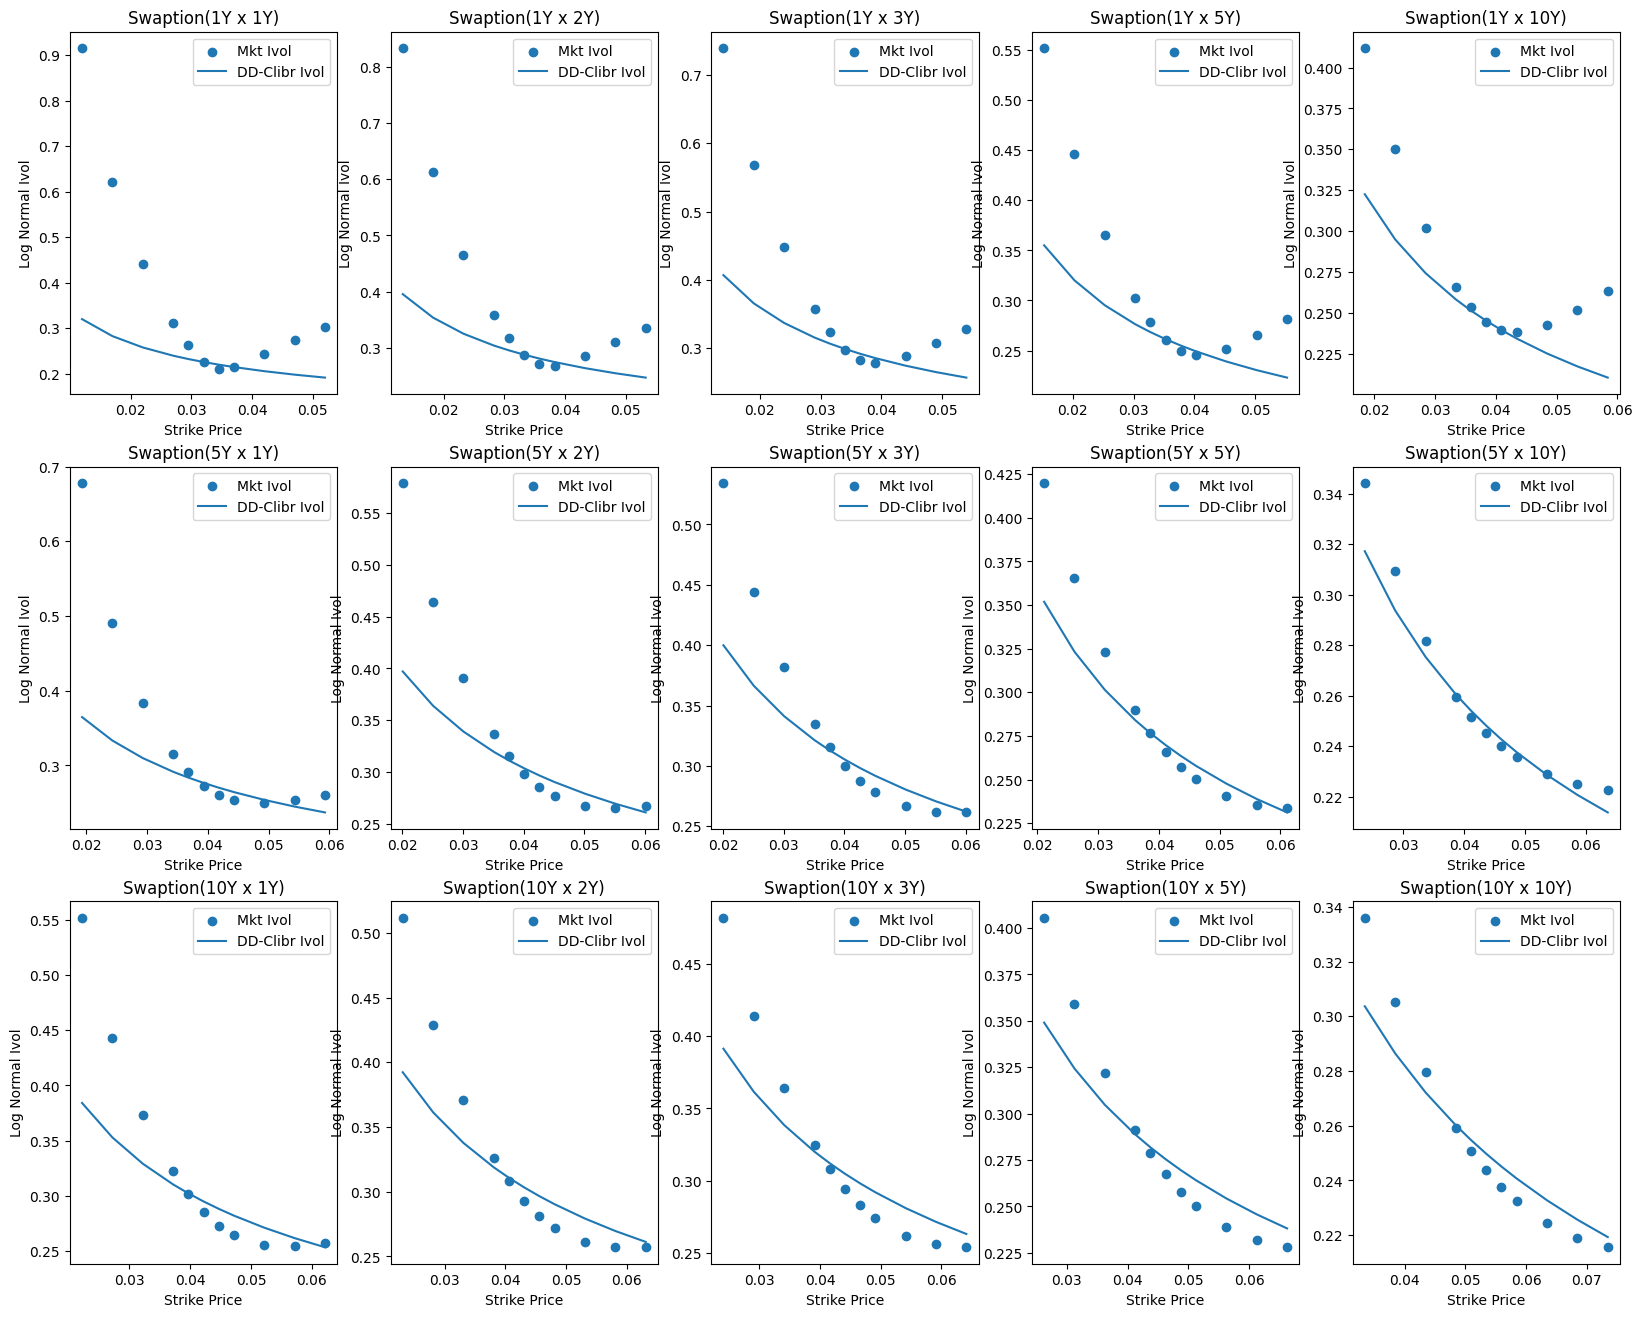

In [10]:
plt.figure(figsize=(20,16))
for i in range(len(fsr)):
    plt.subplot(3,5,i+1)
    S = fsr.iloc[i].iloc[2]
    strikes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] + S
    plt.scatter(strikes, fsr.iloc[i].iloc[4:15], label = 'Mkt Ivol')
    plt.plot(strikes, cal_dd_vol(fsr.iloc[i]), label = 'DD-Clibr Ivol')
    plt.legend()
    plt.ylabel('Log Normal Ivol')
    plt.xlabel('Strike Price')
    plt.title('Swaption('+ str(int(fsr.iloc[i].iloc[0])) + 'Y x ' + str(int(fsr.iloc[i].iloc[1])) + 'Y)')

# SABR

In [11]:
# def SABR(F, K, T, alpha, beta, rho, nu):
#     X = K
#     if F == K:
#         numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
#         numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
#         numer3 = ((2 - 3*rho*rho)/24)*nu*nu
#         VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
#         sabrsigma = VolAtm
#     else:
#         z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
#         zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
#         numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
#         numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
#         numer3 = ((2 - 3*rho*rho)/24)*nu*nu
#         numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
#         denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
#         denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
#         denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
#         sabrsigma = numer/denom
#     return sabrsigma


In [12]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    # if abs(F - K) < 1e-12:
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        # if np.isnan(zhi):
        #     print((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        #     return
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [13]:
def sabrcalibration(x, row, beta):    #x is a df there
    err = 0.0
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    vols = row.iloc[4:15]
    # print(vols)
    # return
    #S = row.iloc[2]
    #F = row.iloc[2]*row.iloc[3]
    F = row.iloc[2]
    T = row.iloc[0]
    
    for i, vol in enumerate(vols):
        K = F + bp_changes[i]
        # print(F,K,T,beta, vol)
        # return
        err += (vol - SABR(F, K, T, x[0], beta, x[1], x[2]))**2
    return err

In [44]:
def sabr_vol(row):
    beta = 0.9 
    #sarb to fit market vol
    initialGuess = [0.190534, -0.519452, 1.049854]
    #initialGuess = [0.02, 0.2, 0.1]
    #res = least_squares(lambda x: sabrcalibration(x, row, beta), initialGuess, bounds=([0,-1,0],[5,1,5]))
    res = least_squares(lambda x: sabrcalibration(x, row, beta), initialGuess)
    alpha1 = res.x[0]
    rho1 = res.x[1]
    nu1 = res.x[2]

    return [alpha1, rho1, nu1]

In [15]:
def cal_sabr_vols(row):    #x is a df there
    beta = 0.9
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    alpha = row.iloc[-3]
    rho = row.iloc[-2]
    nu = row.iloc[-1]
    # print(vols)
    # return
    #S = row.iloc[2]
    #F = row.iloc[2]*row.iloc[3]
    F = row.iloc[2]
    T = row.iloc[0]
    vols = []
    
    for i in range(len(bp_changes)):
        K = F + bp_changes[i]
        # print(F,K,T,beta, vol)
        # return
        vols.append(SABR(F, K, T, alpha, beta, rho, nu))
    return vols

In [33]:
[sabr_vol(fsr.iloc[i]) for i in range(len(fsr))]

[[0.1390554196883563, -0.6331042105905816, 2.049386476577526],
 [0.1844842063013948, -0.5254447250181702, 1.6794366582354094],
 [0.19658039811233416, -0.4812024019970762, 1.4393412408863027],
 [0.1780111036048773, -0.41415231884849135, 1.0653367534760914],
 [0.16889696883047348, -0.2505321067984187, 0.8063425511314288],
 [0.1655777092799978, -0.5808576538743006, 1.3341691510375246],
 [0.19710749320037654, -0.5370212777414657, 1.0572581372295997],
 [0.20503647635284342, -0.5308628022546489, 0.9376503814817394],
 [0.1865422645661212, -0.4935054862693207, 0.697215008494995],
 [0.16606604947512937, -0.36710379096289497, 0.5848966309949267],
 [0.1756639772248912, -0.5396933836145165, 1.0012674832090036],
 [0.19404549600503193, -0.5418236029909211, 0.9245479629801848],
 [0.20902784503140437, -0.556611515046545, 0.8768054311658287],
 [0.21073047040603451, -0.5902426087982899, 0.7439828211503368],
 [0.17785410873989443, -0.5001043726976507, 0.5900217308815197]]

In [46]:
lst = [sabr_vol(fsr.iloc[i]) for i in range(len(fsr))]
fsr['alpha'] = np.array(lst)[:,0]
fsr['rho'] = np.array(lst)[:,1]
fsr['nu'] = np.array(lst)[:,2]

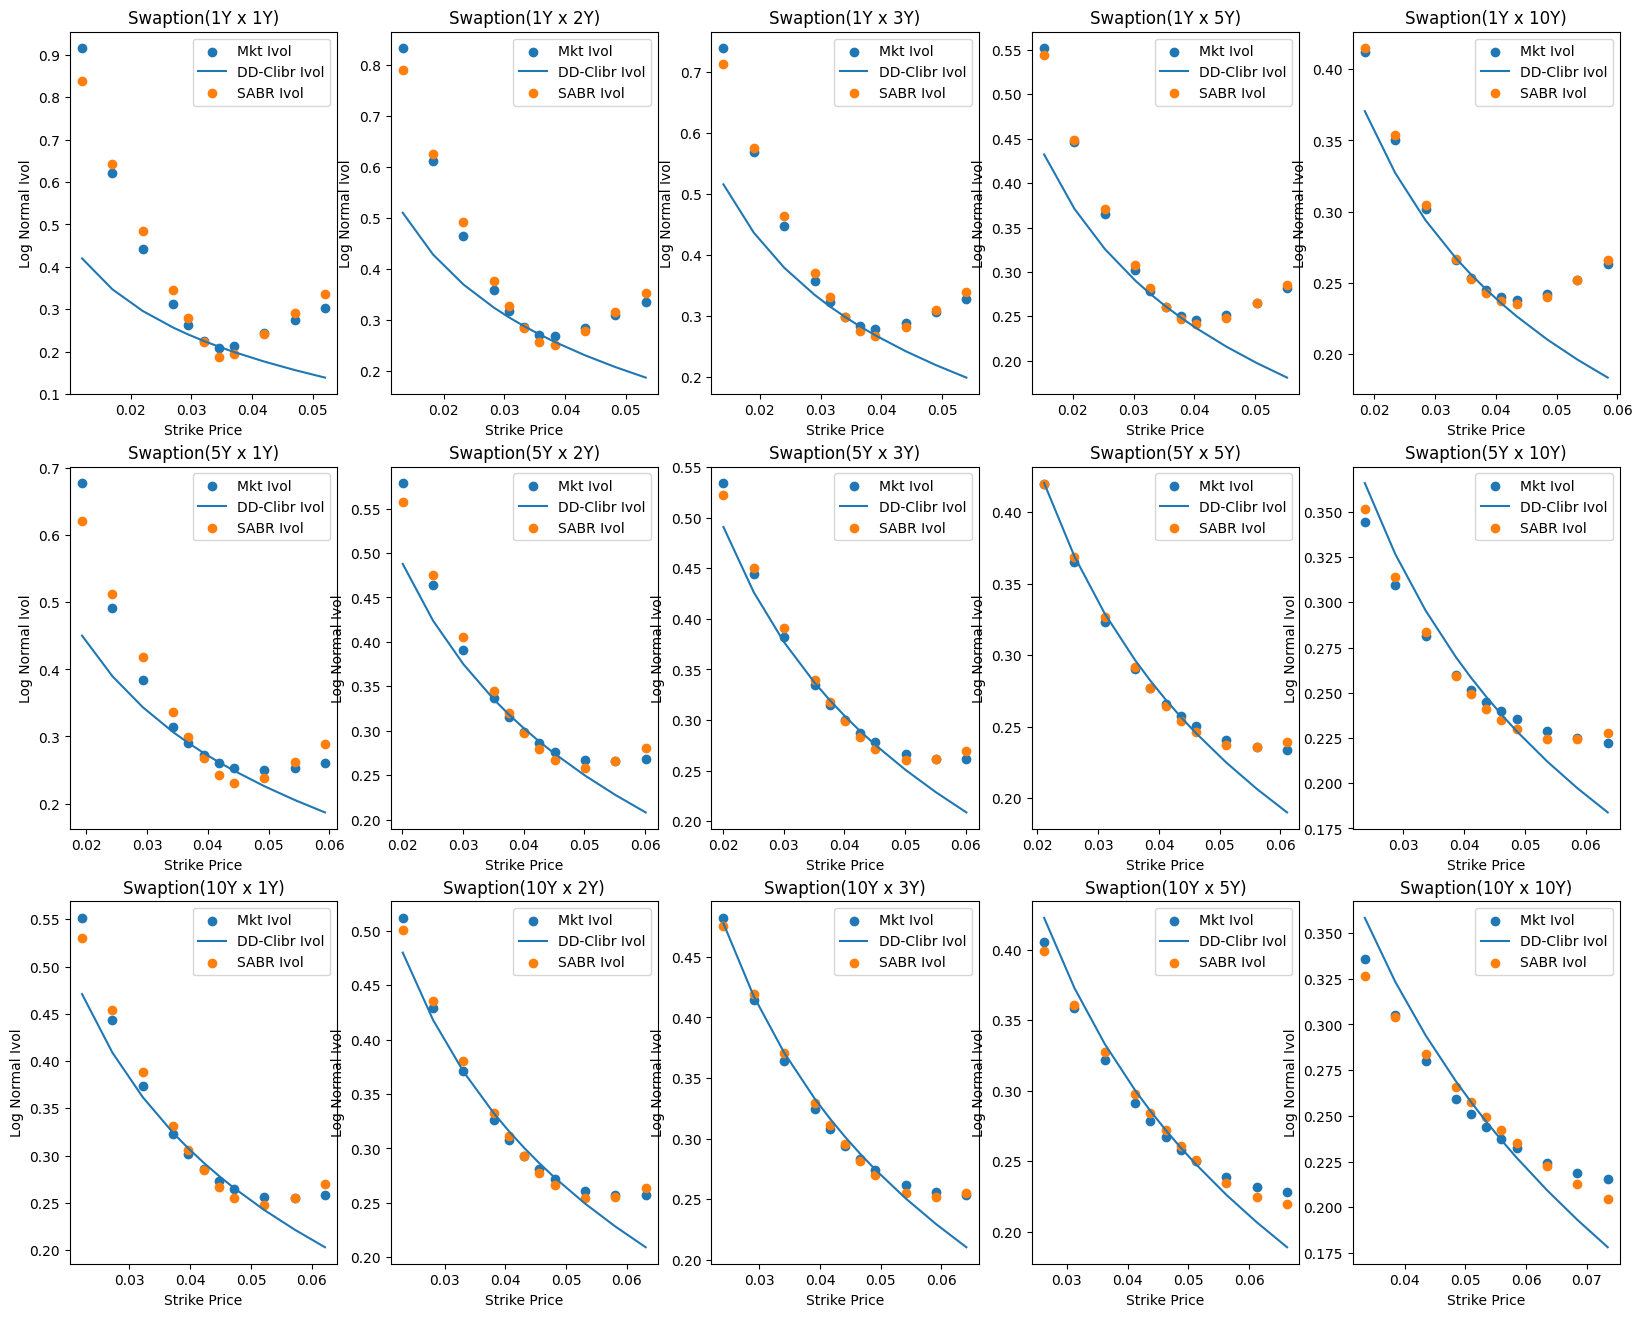

In [51]:
plt.figure(figsize=(20,16))
for i in range(len(fsr)):
    plt.subplot(3,5,i+1)
    S = fsr.iloc[i].iloc[2]
    strikes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] + S
    plt.scatter(strikes, fsr.iloc[i].iloc[4:15], label = 'Mkt Ivol')
    plt.plot(strikes, cal_dd_vol(fsr.iloc[i]), label = 'DD-Clibr Ivol')
    plt.scatter(strikes, cal_sabr_vols(fsr.iloc[i]), label = 'SABR Ivol')
    plt.legend()
    plt.ylabel('Log Normal Ivol')
    plt.xlabel('Strike Price')
    plt.title('Swaption('+ str(int(fsr.iloc[i].iloc[0])) + 'Y x ' + str(int(fsr.iloc[i].iloc[1])) + 'Y)')